In [20]:
import pandas as pd
import yaml
import joblib
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from modeling import create_model, update_config

In [21]:
pbp = pd.read_parquet('data/pbp.parquet')
pbp['year'] = pbp['game_id'].apply(lambda x: int(x.split('_')[0]))
pbp['posteam'] = pbp['posteam'].bfill(limit=1)
pbp['defteam'] = pbp['defteam'].bfill(limit=1)
print(pbp.columns)

Index(['play_id', 'game_id', 'old_game_id', 'home_team', 'away_team',
       'season_type', 'week', 'posteam', 'posteam_type', 'defteam',
       ...
       'defense_players', 'n_offense', 'n_defense', 'ngs_air_yards',
       'time_to_throw', 'was_pressure', 'route', 'defense_man_zone_type',
       'defense_coverage_type', 'year'],
      dtype='object', length=393)


In [22]:
team = pd.read_csv('data/agg/team_stats.csv', index_col=0)
opp = pd.read_csv('data/agg/opp_stats.csv', index_col=0)
team_stat_cols = [
 'completions_team_roll',
 'attempts_team_roll',
 'carries_team_roll',
 'passing_yards_team_roll',
 'rushing_yards_team_roll',
 'pass_pct_team_roll',
 'completions_opp_roll',
 'attempts_opp_roll',
 'carries_opp_roll',
 'passing_yards_opp_roll',
 'rushing_yards_opp_roll',
 'pass_pct_opp_roll']

In [23]:
team

,recent_team,season,week,completions_team_roll,attempts_team_roll,carries_team_roll,passing_yards_team_roll,rushing_yards_team_roll,pass_pct_team_roll,receiving_yards_team_roll
0,ARI,2010,1,22.000000,41.000000,21.000000,297.000000,112.000000,0.661290,297.000000
1,ATL,2010,1,27.000000,44.000000,25.000000,252.000000,58.000000,0.637681,252.000000
2,BAL,2010,1,20.000000,38.000000,35.000000,248.000000,49.000000,0.520548,248.000000
3,BUF,2010,1,18.000000,34.000000,17.000000,139.000000,50.000000,0.666667,139.000000
4,CAR,2010,1,14.000000,35.000000,24.000000,182.000000,89.000000,0.593220,182.000000
...,...,...,...,...,...,...,...,...,...,...
8084,SEA,2024,12,23.714286,35.285714,22.142857,269.714286,79.285714,0.615299,269.714286
8085,SF,2024,12,16.571429,25.428571,22.571429,205.428571,114.571429,0.536039,205.428571
8086,TB,2024,12,25.142857,35.000000,27.285714,259.285714,146.428571,0.557602,258.000000
8087,TEN,2024,12,19.428571,31.000000,28.000000,223.428571,122.428571,0.527266,223.428571


In [24]:
pbp = pbp.merge(team, left_on=['posteam','season','week'], right_on=['recent_team','season','week']).drop('recent_team',axis=1)
pbp = pbp.merge(opp, left_on=['defteam','season','week'], right_on=['opponent_team','season','week']).drop('opponent_team',axis=1)
pbp.sample(5)

,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,rushing_yards_team_roll,pass_pct_team_roll,receiving_yards_team_roll,completions_opp_roll,attempts_opp_roll,carries_opp_roll,passing_yards_opp_roll,rushing_yards_opp_roll,pass_pct_opp_roll,receiving_yards_opp_roll
663491,3336.0,2023_07_LAC_KC,None,KC,LAC,REG,7,KC,home,LAC,...,111.285714,0.596990,292.571429,26.428571,39.571429,24.142857,328.714286,99.714286,0.614909,328.714286
34232,2488.0,2010_13_JAX_TEN,2010120502,TEN,JAX,REG,13,TEN,home,JAX,...,72.428571,0.619694,179.714286,18.285714,29.142857,27.142857,241.857143,114.285714,0.519726,241.857143
576134,669.0,2021_13_BAL_PIT,None,PIT,BAL,REG,13,BAL,away,PIT,...,145.857143,0.531105,229.142857,21.000000,31.428571,29.142857,237.714286,152.714286,0.519984,237.714286
90936,3686.0,2011_16_ATL_NO,2011122600,NO,ATL,REG,16,ATL,away,NO,...,90.142857,0.602728,318.571429,28.142857,45.142857,21.285714,339.857143,84.571429,0.677749,339.857143
506584,1282.0,2020_05_CIN_BAL,None,BAL,CIN,REG,5,CIN,away,BAL,...,107.285714,0.590089,270.000000,20.714286,33.142857,26.428571,218.857143,109.714286,0.549096,218.857143


In [25]:
small = pbp.loc[pbp.year>2021].dropna(how='all',axis=1)
context_cols = ['play_id','game_id','home_team','away_team','game_half','posteam','side_of_field','desc']
small.loc[~small.down.isna()][context_cols]

,play_id,game_id,home_team,away_team,game_half,posteam,side_of_field,desc
594875,68.0,2022_01_BAL_NYJ,NYJ,BAL,Half1,NYJ,NYJ,(14:56) 32-Mi.Carter left end to NYJ 41 for 19...
594876,89.0,2022_01_BAL_NYJ,NYJ,BAL,Half1,NYJ,NYJ,"(14:29) (No Huddle, Shotgun) 19-J.Flacco pass ..."
594877,115.0,2022_01_BAL_NYJ,NYJ,BAL,Half1,NYJ,NYJ,(14:25) (No Huddle) 32-Mi.Carter left end to N...
594878,136.0,2022_01_BAL_NYJ,NYJ,BAL,Half1,NYJ,NYJ,"(14:01) (No Huddle, Shotgun) 19-J.Flacco pass ..."
594879,172.0,2022_01_BAL_NYJ,NYJ,BAL,Half1,NYJ,NYJ,"(13:53) 7-B.Mann punts 45 yards to BAL 19, Cen..."
...,...,...,...,...,...,...,...,...
728379,4171.0,2024_12_TEN_HOU,HOU,TEN,Half2,HOU,HOU,(1:29) (Shotgun) 7-C.Stroud pass incomplete de...
728380,4194.0,2024_12_TEN_HOU,HOU,TEN,Half2,HOU,HOU,(1:23) (Shotgun) 7-C.Stroud sacked at HOU 1 fo...
728382,4214.0,2024_12_TEN_HOU,HOU,TEN,Half2,HOU,HOU,(1:17) (Shotgun) 7-C.Stroud sacked in End Zone...
728385,4281.0,2024_12_TEN_HOU,HOU,TEN,Half2,TEN,HOU,(1:12) 8-W.Levis kneels to HOU 30 for -1 yards.


In [26]:
play_type_mapping = {
    'field_goal': 0,
    'no_play': 1,
    'pass': 2,
    'punt': 3,
    'qb_kneel': 4,
    'qb_spike': 5,
    'run': 6,
    np.nan: 7
}

In [27]:
x_cols = [
    #'posteam',
    "yardline_100",
    "down",
    "goal_to_go",
    "ydstogo",
    #"yards_gained",
    "posteam_score",
    #"total_away_score",
    "score_differential",
    'quarter_seconds_remaining',
    'half_seconds_remaining',
    'game_seconds_remaining',
    "wind",
    "temp",
    'spread_line',
    'total_line'
] + team_stat_cols

small["play_type_enc"] = small['play_type'].map(play_type_mapping)
y_col = ["play_type_enc"]
data = small.loc[(~small.down.isna()) & (~small.rush_attempt.isna()) & ~(small.play_type.isna())][x_cols + y_col]
data = data.loc[~data.play_type_enc.isna()]


In [28]:
play_type_model = create_model(data, x_cols, y_col[0], colsample_bytree=0.8)
print(x_cols)
#0.67
_ = '''array([[ 550,    1,   21,   13,    0,    4,   16],
       [  25,    0,  806,   55,    3,    0,  410],
       [  48,    9, 8092,   32,    5,    4, 2771],
       [   4,    2,   13, 1165,    0,    0,   15],
       [   0,    0,   18,    0,  202,    0,   16],
       [  10,    0,   24,    0,    0,    3,    0],
       [  16,    2, 2933,   27,   21,    1, 5137]], dtype=int64)'''

Accuracy: 0.68
Confusion Matrix:


array([[ 557,    1,   16,   10,    0,    3,   18],
       [  27,    2,  806,   55,    3,    0,  406],
       [  48,    3, 8081,   32,    4,    3, 2790],
       [   4,    3,    7, 1169,    0,    0,   16],
       [   0,    0,   23,    0,  199,    0,   14],
       [  10,    0,   24,    0,    0,    3,    0],
       [  15,    4, 2914,   24,   21,    0, 5159]], dtype=int64)

['yardline_100', 'down', 'goal_to_go', 'ydstogo', 'posteam_score', 'score_differential', 'quarter_seconds_remaining', 'half_seconds_remaining', 'game_seconds_remaining', 'wind', 'temp', 'spread_line', 'total_line', 'completions_team_roll', 'attempts_team_roll', 'carries_team_roll', 'passing_yards_team_roll', 'rushing_yards_team_roll', 'pass_pct_team_roll', 'completions_opp_roll', 'attempts_opp_roll', 'carries_opp_roll', 'passing_yards_opp_roll', 'rushing_yards_opp_roll', 'pass_pct_opp_roll']


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

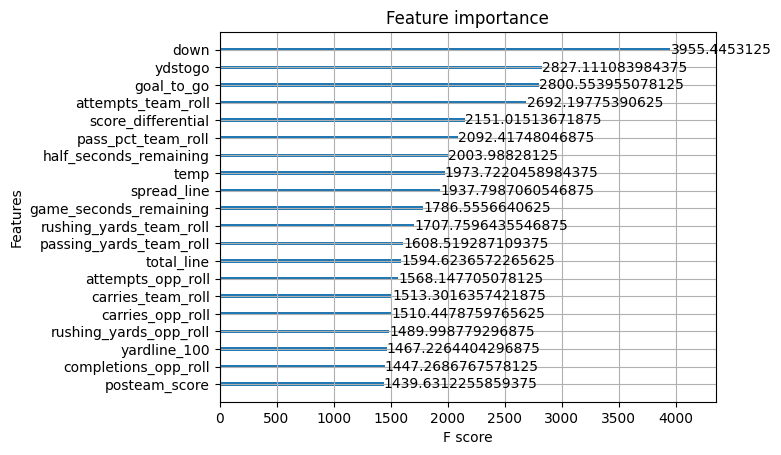

In [29]:
xgb.plot_importance(play_type_model,importance_type= 'cover', max_num_features=20)

In [30]:
joblib.dump(play_type_model, 'models/run_or_pass.joblib')

['models/run_or_pass.joblib']

In [31]:
{k:v for v,k in play_type_mapping.items()}

{0: 'field_goal',
 1: 'no_play',
 2: 'pass',
 3: 'punt',
 4: 'qb_kneel',
 5: 'qb_spike',
 6: 'run',
 7: nan}

In [32]:
feature_config = {
    'run_or_pass_cols':x_cols,
    'play_encoding': {k:v for v,k in play_type_mapping.items()}
}
update_config(feature_config)

In [34]:
small.loc[small.play_type=='no_play'][['desc','first_down_penalty',
 'penalty',
 'penalty_team',
 'penalty_player_id',
 'penalty_player_name',
 'penalty_yards',
 'penalty_type',
 'drive_yards_penalized']].sample(10)

,desc,first_down_penalty,penalty,penalty_team,penalty_player_id,penalty_player_name,penalty_yards,penalty_type,drive_yards_penalized
634656,Timeout #2 by CAR at 02:55.,0.0,0.0,None,None,None,NaN,None,-5.0
599116,(13:38) (Shotgun) 15-P.Mahomes pass deep right...,1.0,1.0,LAC,00-0031904,B.Callahan,5.0,Illegal Contact,5.0
626214,Timeout #1 by NE at 01:35.,0.0,0.0,None,None,None,NaN,None,5.0
697406,(4:49) (Shotgun) 7-G.Smith pass short right to...,0.0,1.0,SEA,00-0035640,D.Metcalf,10.0,Offensive Pass Interference,-10.0
629614,Timeout #1 by WAS at 00:39.,0.0,0.0,None,None,None,NaN,None,0.0
645929,"(2:58) (No Huddle, Shotgun) 9-B.Young pass inc...",1.0,1.0,ATL,00-0034756,T.Flowers,9.0,Defensive Pass Interference,4.0
617168,(3:12) 11-P.Walker pass incomplete deep left t...,1.0,1.0,CIN,00-0037753,C.Taylor-Britt,5.0,Illegal Contact,5.0
661961,Timeout #1 by ATL at 04:07.,0.0,0.0,None,None,None,NaN,None,0.0
628033,"(1:12) (Shotgun) PENALTY on JAX, Delay of Game...",0.0,1.0,JAX,None,None,4.0,Delay of Game,-4.0
660283,Timeout #3 by DEN at 00:22.,0.0,0.0,None,None,None,NaN,None,0.0


In [35]:
small.head(5)[['desc','down','yards_gained']]

,desc,down,yards_gained
594873,GAME,NaN,NaN
594874,9-J.Tucker kicks 68 yards from BAL 35 to NYJ -...,NaN,0.0
594875,(14:56) 32-Mi.Carter left end to NYJ 41 for 19...,1.0,19.0
594876,"(14:29) (No Huddle, Shotgun) 19-J.Flacco pass ...",1.0,0.0
594877,(14:25) (No Huddle) 32-Mi.Carter left end to N...,2.0,5.0


In [36]:
[x for x in small.columns if 'rush' in x.lower()]

['total_home_rush_epa',
 'total_away_rush_epa',
 'total_home_rush_wpa',
 'total_away_rush_wpa',
 'first_down_rush',
 'rush_attempt',
 'rush_touchdown',
 'lateral_rush',
 'rusher_player_id',
 'rusher_player_name',
 'rushing_yards',
 'lateral_rusher_player_id',
 'lateral_rusher_player_name',
 'lateral_rushing_yards',
 'rusher',
 'rusher_jersey_number',
 'rush',
 'rusher_id',
 'number_of_pass_rushers',
 'rushing_yards_team_roll',
 'rushing_yards_opp_roll']

In [37]:
small.loc[(small.rusher_player_name=='S.Barkley')
          &
          (small.goal_to_go == 1)][['week','home_team','away_team','rusher_player_name','goal_to_go','yardline_100','yards_gained', 'ydstogo', 'rush', 'rushing_yards', 'rush_touchdown']].reset_index(drop=True)

,week,home_team,away_team,rusher_player_name,goal_to_go,yardline_100,yards_gained,ydstogo,rush,rushing_yards,rush_touchdown
0,1,TEN,NYG,S.Barkley,1,4.0,4.0,4.0,1.0,4.0,1.0
1,1,TEN,NYG,S.Barkley,1,3.0,2.0,3.0,1.0,2.0,0.0
2,2,NYG,CAR,S.Barkley,1,5.0,3.0,5.0,1.0,3.0,0.0
3,5,GB,NYG,S.Barkley,1,2.0,2.0,2.0,1.0,2.0,1.0
4,6,NYG,BAL,S.Barkley,1,10.0,5.0,10.0,1.0,5.0,0.0
5,6,NYG,BAL,S.Barkley,1,1.0,1.0,1.0,1.0,1.0,1.0
6,8,SEA,NYG,S.Barkley,1,2.0,1.0,2.0,1.0,1.0,0.0
7,8,SEA,NYG,S.Barkley,1,1.0,1.0,1.0,1.0,1.0,1.0
8,10,NYG,HOU,S.Barkley,1,11.0,2.0,11.0,1.0,2.0,0.0
9,10,NYG,HOU,S.Barkley,1,4.0,2.0,4.0,1.0,2.0,0.0


In [38]:
r_data = small.loc[small.rush==1]
r_data
rx_cols = [
    #'posteam',
    "yardline_100",
    "down",
    "goal_to_go",
    "ydstogo",
    #"yards_gained",
    "posteam_score",
    "total_away_score",
    "score_differential",
    'quarter_seconds_remaining',
    'half_seconds_remaining',
    'game_seconds_remaining',
    "wind",
    "temp",
    'spread_line',
    'total_line'
]
r_data[context_cols + rx_cols]

,play_id,game_id,home_team,away_team,game_half,posteam,side_of_field,desc,yardline_100,down,...,posteam_score,total_away_score,score_differential,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,wind,temp,spread_line,total_line
594875,68.0,2022_01_BAL_NYJ,NYJ,BAL,Half1,NYJ,NYJ,(14:56) 32-Mi.Carter left end to NYJ 41 for 19...,78.0,1.0,...,0.0,0.0,0.0,896.0,1796.0,3596.0,8.554289,57.110649,6.5,44.0
594877,115.0,2022_01_BAL_NYJ,NYJ,BAL,Half1,NYJ,NYJ,(14:25) (No Huddle) 32-Mi.Carter left end to N...,59.0,2.0,...,0.0,0.0,0.0,865.0,1765.0,3565.0,8.554289,57.110649,6.5,44.0
594882,254.0,2022_01_BAL_NYJ,NYJ,BAL,Half1,BAL,BAL,(12:41) (Shotgun) 8-L.Jackson right tackle to ...,64.0,3.0,...,0.0,0.0,0.0,761.0,1661.0,3461.0,8.554289,57.110649,-6.5,44.0
594883,275.0,2022_01_BAL_NYJ,NYJ,BAL,Half1,BAL,BAL,(12:01) (Shotgun) 17-K.Drake right end to BAL ...,60.0,1.0,...,0.0,0.0,0.0,721.0,1621.0,3421.0,8.554289,57.110649,-6.5,44.0
594885,330.0,2022_01_BAL_NYJ,NYJ,BAL,Half1,BAL,BAL,(10:40) 17-K.Drake right tackle to BAL 49 for ...,52.0,3.0,...,0.0,0.0,0.0,640.0,1540.0,3340.0,8.554289,57.110649,-6.5,44.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728356,3609.0,2024_12_TEN_HOU,HOU,TEN,Half2,HOU,TEN,(7:56) (No Huddle) 28-J.Mixon up the middle to...,47.0,1.0,...,27.0,30.0,-3.0,476.0,476.0,476.0,5.000000,58.000000,-8.0,40.5
728360,3707.0,2024_12_TEN_HOU,HOU,TEN,Half2,TEN,TEN,(6:17) 20-T.Pollard right end to TEN 2 for -4 ...,94.0,1.0,...,30.0,30.0,3.0,377.0,377.0,377.0,5.000000,58.000000,8.0,40.5
728370,3978.0,2024_12_TEN_HOU,HOU,TEN,Half2,HOU,TEN,(2:12) 28-J.Mixon left tackle to TEN 10 for no...,10.0,2.0,...,27.0,30.0,-3.0,132.0,132.0,132.0,5.000000,58.000000,-8.0,40.5
728373,4051.0,2024_12_TEN_HOU,HOU,TEN,Half2,TEN,TEN,(1:53) 61-J.Ojukwu reported in as eligible. 20...,80.0,1.0,...,30.0,30.0,3.0,113.0,113.0,113.0,5.000000,58.000000,8.0,40.5
